<a href="https://colab.research.google.com/github/Lou-kku/Machine-Learning-Programming/blob/main/4%EC%A3%BC%EC%B0%A8/1dcnn_slidingfail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
# -*- coding: utf-8 -*-
"""
mHealth 데이터셋 분석 - 1D CNN 모델

이 스크립트는 mHealth 데이터셋을 로드하고, 1D CNN 모델을 사용하여
사용자의 활동을 분류합니다. 전체 과정은 다음과 같습니다.
1.  데이터 로딩 및 통합
2.  전처리 (Null Class 제거)
3.  시계열 데이터 변환 (Sliding Window)
4.  데이터 분할
5.  1D CNN 모델 구축
6.  모델 학습
7.  모델 평가 및 결과 시각화
"""

# 1. 라이브러리 임포트
import os
import glob
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

# 재현성을 위한 시드 설정
tf.random.set_seed(42)
np.random.seed(42)


In [34]:
# 2. 데이터 로딩 및 통합 함수
def load_and_combine_data(data_path='/content/drive/MyDrive/mhealth'):
    log_files = glob.glob(os.path.join(data_path, 'mHealth_subject*.log'))
    all_df_list = []
    column_names = [
        'acc_chest_x', 'acc_chest_y', 'acc_chest_z', 'ecg_lead1', 'ecg_lead2',
        'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z', 'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z',
        'mag_ankle_x', 'mag_ankle_y', 'mag_ankle_z', 'acc_arm_x', 'acc_arm_y', 'acc_arm_z',
        'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z', 'mag_arm_x', 'mag_arm_y', 'mag_arm_z', 'label'
    ]
    for file in log_files:
        subject_id = int(os.path.basename(file).split('subject')[1].split('.')[0])
        df = pd.read_csv(file, header=None, sep='\t', names=column_names)
        df['subject'] = subject_id
        all_df_list.append(df)
    combined_df = pd.concat(all_df_list, ignore_index=True)
    return combined_df


In [35]:
# 3. 슬라이딩 윈도우 함수
def create_sequences(X, y, time_steps, step):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels, keepdims=True)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)


In [36]:
# --- 데이터 처리 및 모델링 ---
# 데이터 로딩
print("--- 데이터 로딩 및 통합 ---")
df = load_and_combine_data()
print("데이터 로딩 완료. 총 행의 수:", len(df))


--- 데이터 로딩 및 통합 ---
데이터 로딩 완료. 총 행의 수: 1215745


In [37]:
# 전처리: Null Class (label 0) 제거
print("\n--- 전처리 ---")
df_cleaned = df[df['label'] != 0].copy()
# 레이블을 0-11 범위로 조정
df_cleaned['label'] = df_cleaned['label'] - 1
print("Null Class 제거 및 레이블 조정 완료.")



--- 전처리 ---
Null Class 제거 및 레이블 조정 완료.


In [38]:
# 피처와 레이블 분리
features = df_cleaned.drop(['label', 'subject'], axis=1)
labels = df_cleaned['label']


In [39]:
# 시계열 데이터를 시퀀스로 변환
print("\n--- 슬라이딩 윈도우 적용 ---")
WINDOW_SIZE = 128
STEP = 64
X_seq, y_seq = create_sequences(features, labels, WINDOW_SIZE, STEP)
print(f"생성된 시퀀스 데이터 형태: {X_seq.shape}")



--- 슬라이딩 윈도우 적용 ---
생성된 시퀀스 데이터 형태: (5361, 128, 23)


In [40]:
# 데이터 분할 (훈련, 검증, 테스트)
print("\n--- 데이터 분할 ---")
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_seq, y_seq, test_size=0.15, random_state=42, stratify=y_seq)
val_size_relative = 0.15 / 0.85
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=val_size_relative, random_state=42, stratify=y_train_val)
print(f"훈련 데이터: {X_train.shape}, 검증 데이터: {X_val.shape}, 테스트 데이터: {X_test.shape}")



--- 데이터 분할 ---
훈련 데이터: (3752, 128, 23), 검증 데이터: (804, 128, 23), 테스트 데이터: (805, 128, 23)


In [41]:
print("\n--- 피처 스케일링 (Standardization) ---")

# StandardScaler는 2D 데이터에 적용해야 하므로, 3D 데이터를 2D로 변환
# (샘플 수 * 시퀀스 길이, 피처 수) 형태로 변환
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_val_reshaped = X_val.reshape(-1, X_val.shape[-1])
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

# 훈련 데이터 기준으로 스케일러 학습
scaler = StandardScaler()
scaler.fit(X_train_reshaped)

# 모든 데이터를 학습된 스케일러로 변환
X_train_scaled_reshaped = scaler.transform(X_train_reshaped)
X_val_scaled_reshaped = scaler.transform(X_val_reshaped)
X_test_scaled_reshaped = scaler.transform(X_test_reshaped)

# 모델에 입력하기 위해 다시 원래의 3D 형태로 복원
X_train = X_train_scaled_reshaped.reshape(X_train.shape)
X_val = X_val_scaled_reshaped.reshape(X_val.shape)
X_test = X_test_scaled_reshaped.reshape(X_test.shape)

print("피처 스케일링 완료.")


--- 피처 스케일링 (Standardization) ---
피처 스케일링 완료.


In [42]:
# 1D CNN 모델 구축
print("\n--- 1D CNN 모델 구축 ---")
N_FEATURES = X_train.shape[2]
N_CLASSES = len(np.unique(y_seq))
INPUT_SHAPE = (WINDOW_SIZE, N_FEATURES)

model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=INPUT_SHAPE),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(N_CLASSES, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()



--- 1D CNN 모델 구축 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 126, 64)        │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4032)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       516,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 522,252 (1.99 MB)

 Trainable params: 522,252 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
# 모델 학습
print("\n--- 1D CNN 모델 학습 ---")
EPOCHS = 20
BATCH_SIZE = 64
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)



--- 1D CNN 모델 학습 ---
Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6335 - loss: 1.1618 - val_accuracy: 0.9565 - val_loss: 0.1684
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9732 - loss: 0.1120 - val_accuracy: 0.9726 - val_loss: 0.0918
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9931 - loss: 0.0380 - val_accuracy: 0.9677 - val_loss: 0.1022
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9925 - loss: 0.0283 - val_accuracy: 0.9801 - val_loss: 0.0728
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9977 - loss: 0.0117 - val_accuracy: 0.9764 - val_loss: 0.0749
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9993 - loss: 0.0075 - val_accuracy: 0.9826 - val_loss: 0.0571
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9999 - loss: 0.0049 - val_accuracy: 0.9826 - val_loss: 0.0588
Epoch 8/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9984 - loss: 0.0058 - va

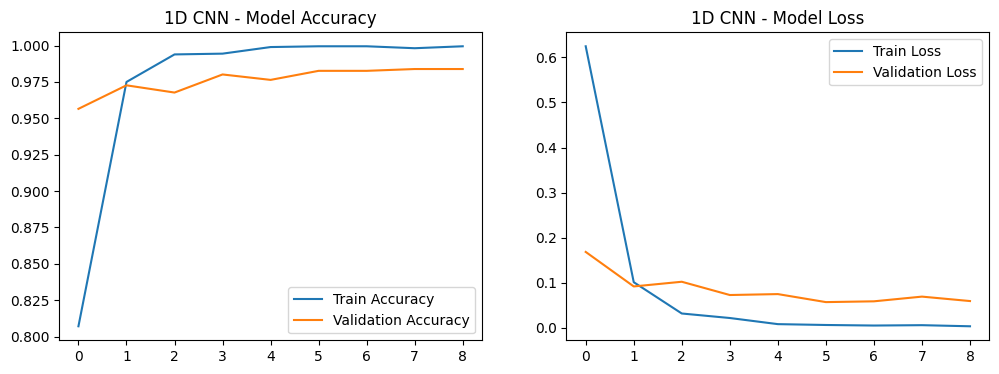

In [44]:
# 학습 과정 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('1D CNN - Model Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('1D CNN - Model Loss')
plt.legend()
plt.show()


In [45]:
# 모델 평가
print("\n--- 1D CNN 모델 평가 ---")
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

activity_labels = [
    "Standing still", "Sitting and relaxing", "Lying down", "Walking",
    "Climbing stairs", "Waist bends forward", "Frontal elevation of arms",
    "Knees bending (crouching)", "Cycling", "Jogging", "Running", "Jump front & back"
]

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=activity_labels))



--- 1D CNN 모델 평가 ---
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Classification Report:
                           precision    recall  f1-score   support

           Standing still       0.99      0.99      0.99        73
     Sitting and relaxing       0.99      0.99      0.99        72
               Lying down       1.00      1.00      1.00        72
                  Walking       1.00      1.00      1.00        72
          Climbing stairs       0.99      0.99      0.99        72
      Waist bends forward       1.00      0.98      0.99        66
Frontal elevation of arms       0.99      0.97      0.98        69
Knees bending (crouching)       0.97      1.00      0.99        69
                  Cycling       0.99      0.99      0.99        72
                  Jogging       0.94      1.00      0.97        72
                  Running       1.00      0.94      0.97        72
        Jump front & back       1.00      0.96      0.98        24

                 accuracy                 

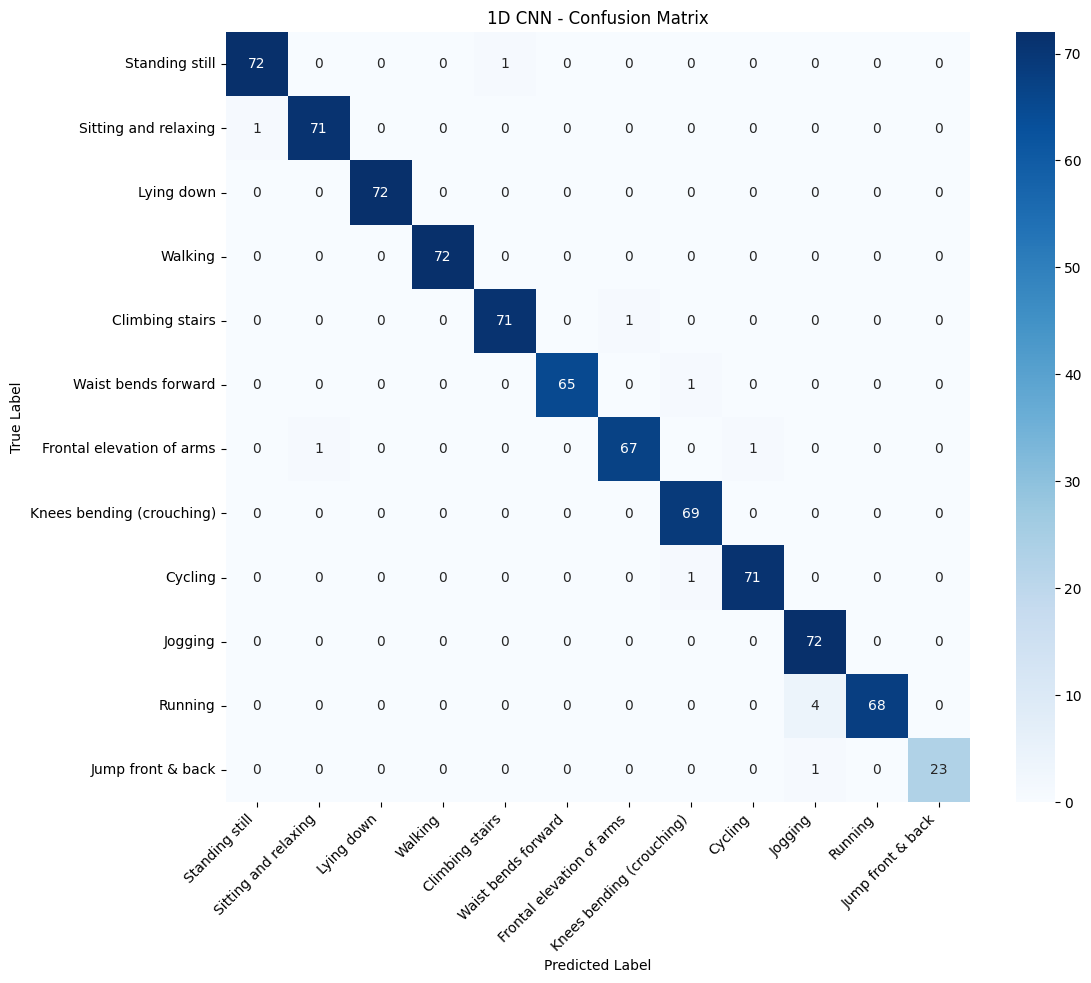

In [46]:
# 혼동 행렬 시각화
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=activity_labels, yticklabels=activity_labels)
plt.title('1D CNN - Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()